# PhaseAutoEncoder for GENEA 2023 challenge
Here we are trying to adapt PhaseAutoEncoder (PAE) from Sebastian Starke (https://github.com/sebastianstarke/AI4Animation) to conversational gesture generation in GENEA 2023 Challange (https://genea-workshop.github.io/2023/challenge/)

## Data preparation
First, we need to represent our data to fit PAE. For this we are trying to parse example dataset from original repo.

In [9]:
import numpy as np
from pathlib import Path
import array
import matplotlib.pyplot as plt
import torch
from scipy.spatial.transform import Rotation as R
from pymo.parsers import BVHParser

from src.utils.processing import get_pose, extract_edges, pose_from_numpy
from src.utils.plotting import skeleton_gif2d, skeleton_pose2d
bvh_parser = BVHParser()

### Parsing PAE input data
Here we explore input data from DeepPhase tutorial. For that folow step-by-step on `Network.py` script.

In [31]:
dataset_folder = Path("./data/PAE_Dataset/")
datashape_path = dataset_folder / "DataShape.txt"
data_path = dataset_folder / "Data.bin"
sequences_path = dataset_folder / "Sequences.txt"

In [32]:
datashape = np.loadtxt(datashape_path, dtype=np.int64)
sample_count, feature_dim = datashape
print(sample_count, feature_dim)

342248 78


In [33]:
def read_binary(binary_file, sample_count, feature_dim, verbose_step: int = 1000):
    bytes_perline = feature_dim*4
    data = []
    with open(binary_file, "rb") as f:
        for i in np.arange(sample_count):
            if i % max(int(sample_count / verbose_step), 1) == 0:
                print('Reading binary ' + str(binary_file) + '...', round(100 * i / sample_count, 2), "%", end="\r")
            f.seek(i*bytes_perline)
            line_bytes = f.read(bytes_perline)
            buffer = array.array('f', line_bytes)
            data.append(np.float32(buffer))
    print('Reading binary ' + str(binary_file) + '...', 100, "%", end="\r")
    print("")
    return np.concatenate(data).reshape(sample_count, -1)

data = read_binary(data_path, sample_count, feature_dim)
data.shape

Reading binary data/PAE_Dataset/Data.bin... 100 % %


(342248, 78)

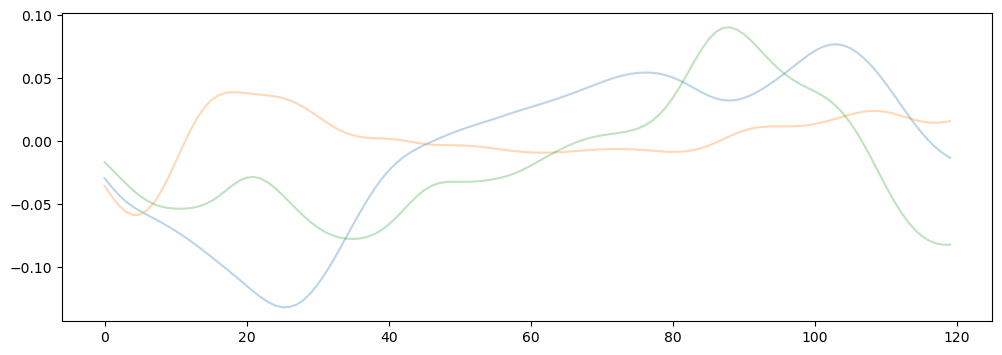

In [34]:
# plot some values
byaxes = data.reshape(342248, 26,3)
plt.figure(figsize=(12,4))
plt.plot(byaxes[:60*2,5,0], alpha=0.3)
plt.plot(byaxes[:60*2,5,1],alpha=0.3)
plt.plot(byaxes[:60*2,5,2], alpha=0.3)

Text(0.5, 1.0, 'by Z')

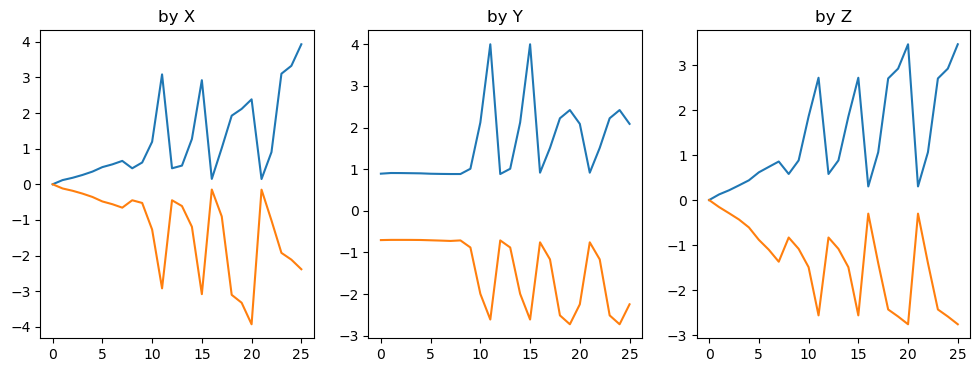

In [35]:
# also interesting min and max by axes and joints
maxes = byaxes.max(axis=0)
mins = byaxes.min(axis=0)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(maxes[:,0])
ax1.plot(mins[:,0])
ax1.set_title('by X')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(maxes[:,1])
ax2.plot(mins[:,1])
ax2.set_title('by Y')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(maxes[:,2])
ax3.plot(mins[:,2])
ax3.set_title('by Z')

In [36]:
def load_sequences(sequences_path, line_count):
    print("Loading" + str(sequences_path))
    data = []
    with open(sequences_path) as f:        
        for pivot, line in enumerate(f):
            entry = line.rstrip().split(' ')
            data.append(entry[0])
            if pivot == line_count:
                break
    return np.array(data, dtype=np.int64)

sequences = load_sequences(sequences_path, sample_count)

Loadingdata/PAE_Dataset/Sequences.txt


In [39]:
data_sequences = [] 
for i in range(sequences[-1]):
    indices = np.where(sequences == (i+1))[0]
    for j in range(indices.shape[0]):
        section = [indices[j], indices[0], indices[-1]]
        data_sequences.append(section) 
        
data_sequences = np.array(data_sequences)
# check if shape of binary data corresponds to sequence metadata
sample_count == len(data_sequences)

True

In [27]:
# now let's look how batch looks like
I = np.arange(sample_count)
train_indices = I[0:32]
train_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

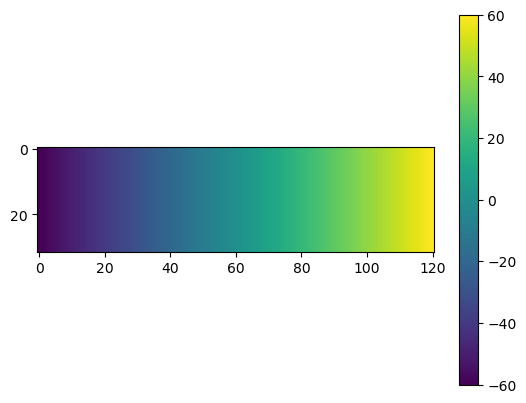

In [47]:
# now let's see how gather window looks like
window = 2.0
fps = 60
frames = int(window * fps) + 1
gather_padding = (int((frames-1)/2))
gather_window = np.arange(frames) - gather_padding
gather = gather_window.reshape(1,-1).repeat(train_indices.shape[0], 0)
plt.imshow(gather)
plt.colorbar()

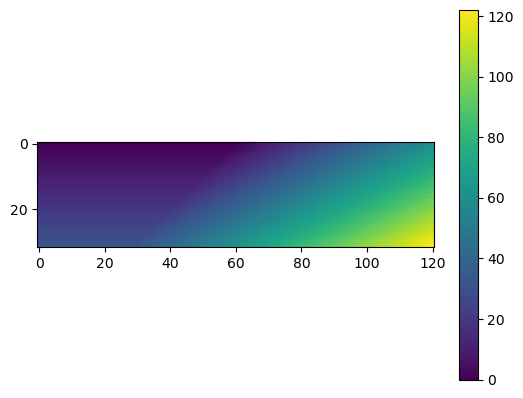

In [49]:
batch_sequences = data_sequences[train_indices]
pivots = batch_sequences[:,0].reshape(-1,1)
mins = batch_sequences[:,1].reshape(-1,1)
maxs = batch_sequences[:,2].reshape(-1,1)
gather = np.clip(gather + pivots, mins, maxs)
plt.imshow(gather)
plt.colorbar()

In [44]:
batch = data[gather.flatten()]
batch.shape
# this tensort goes to NN

(3872, 78)

In [46]:
# and reshaping like that
reshaped_batch = batch.reshape(gather.shape[0], gather.shape[1], -1)
reshaped_batch.shape

(32, 121, 78)

So, we've gotten what input data looks like. But it's also important what exactly this data is.
From C# code it looks like that input data is joints positions velosities. Joint positions were also transformed to charracter root and Butterworth filter was applied to each dimension. So, let's try the same on GENEA dataset.

### Exctract Positions from GENEA sample
First, let's extract positions from bvh use sclearn pipeline:
```
process_motion.py --mode pipeline --pipeline position --src ./data/trn/bvh --pipeline_dir ./pipe
```
```
process_motion.py --mode bvh2npy --src ./data/trn/bvh --dst ./data/trn/position
```

In [14]:
sample_data = np.load('data/pos2/val_2023_v0_000_main-agent.npy')
sample_data.shape

(1830, 78)

(0.0, 200.0)

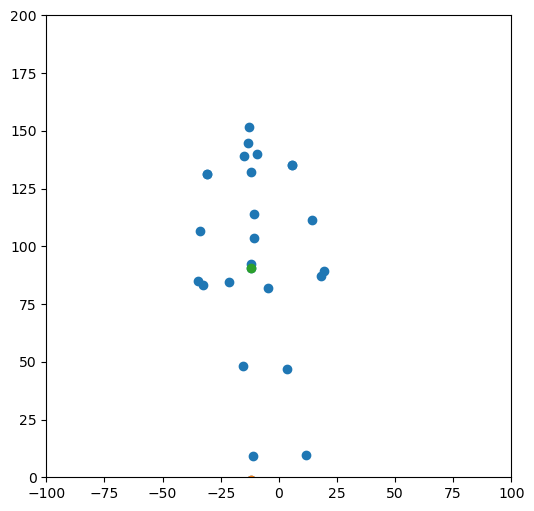

In [16]:
# draw some frame to make shure that extraction works
frame = sample_data[0]
frame_xyz = frame.reshape(-1, 3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(frame_xyz[:,0], frame_xyz[:,1],)
ax.scatter(frame_xyz[:1,0], frame_xyz[:1,1],) # body_world
ax.scatter(frame_xyz[1:2,0], frame_xyz[1:2,1],) # b_root
ax.set_xlim([-100, 100])
ax.set_ylim([0,200])

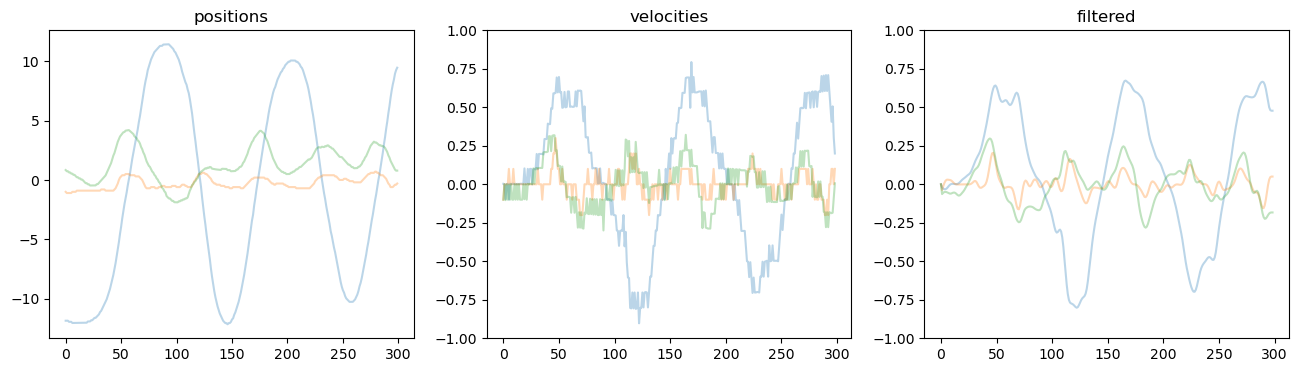

In [17]:
from src.utils.plotting import pos_vel_butter
# than draw posions of some joint along with velocities and Butterworth filter
pos_vel_butter(sample_data, 0)

Now we want to extract velocities, apply Butterworth filter and reconstruct data back.

In [18]:
sample_data.shape

(1830, 78)

In [19]:
# calculate velocities
velocities = np.zeros(sample_data.shape)
velocities[1:] = sample_data[1:] - sample_data[:-1] 
velocities.shape

(1830, 78)

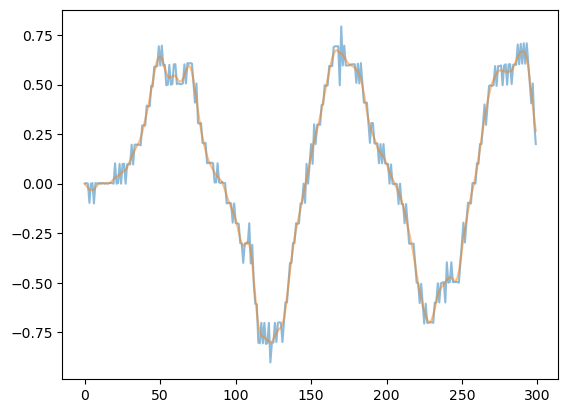

In [20]:
from src.utils.filtering import butter

# draw some velocity curve among with filter applied
plt.plot(velocities[:,0][:300], alpha=0.5)
plt.plot(butter(velocities[:,0])[:300], alpha=0.5)

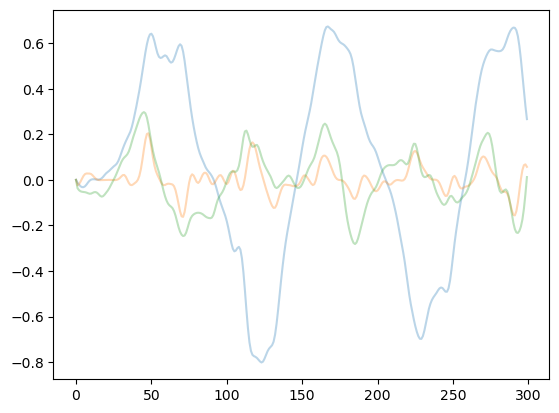

In [21]:
# convert data to smoothed
smoothed_data = np.zeros(velocities.shape)
for i in range(smoothed_data.shape[1]):
    smoothed_data[:,i] = butter(velocities[:, i])
plt.plot(smoothed_data[:300, 0], alpha=0.3)
plt.plot(smoothed_data[:300, 1], alpha=0.3)
plt.plot(smoothed_data[:300, 2], alpha=0.3)

In [22]:
# now we are trying to reconstruct our positions, assume that we know first frame
reconstructed = np.zeros(sample_data.shape)
frame = sample_data[0]
for i in range(smoothed_data.shape[0]):
    frame += smoothed_data[i]
    reconstructed[i] = frame

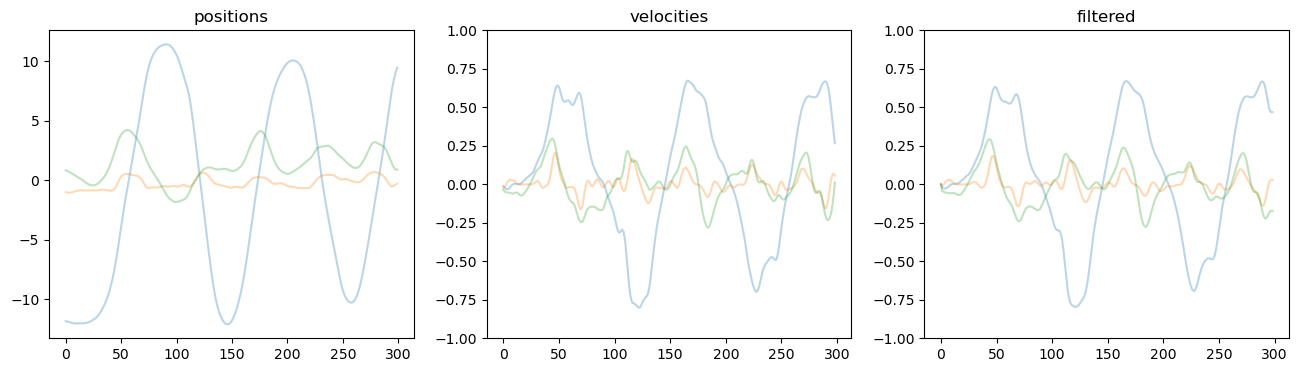

In [23]:
pos_vel_butter(reconstructed, 0)

In [26]:
# looks similar, now let's save reconsructed data and generate bvh 
dst_path = "./data/pos2/val_000_rec.npy"
np.save(dst_path, reconstructed)

# Postion plotting
To visualize resulting animation, first, let's plot them via matplotlib

In [2]:

# sample = bvh_parser.parse('./data/val/main-agent/bvh/val_2023_v0_000_main-agent.bvh')

In [5]:
edges = extract_edges(sample)
poses = []
for i in range(600):
    poses.append(get_pose(sample, i))

In [4]:
skeleton_gif2d(poses, edges, Path('data/sample.gif'))

Now let's plot positions, reconstructed after butter filter 

In [27]:
reconstructed_data = np.load('./data/pos2/val_000_rec.npy')
reconstructed_data.shape

(1830, 78)

In [30]:
filtering_joints = ["body_world", "b_root", "b_spine0", "b_spine1", "b_spine2", "b_spine3", "b_neck0", "b_head", "b_r_shoulder",
                "b_r_arm", "b_r_arm_twist",
                "b_r_forearm", "b_r_wrist_twist",
                "b_r_wrist", "b_l_shoulder",
                "b_l_arm", "b_l_arm_twist",
                "b_l_forearm", "b_l_wrist_twist",
                "b_l_wrist", "b_r_upleg", "b_r_leg",
                "b_r_foot", "b_l_upleg", "b_l_leg", "b_l_foot"]

In [28]:
# generating pretty form
reconstructed_poses = []
for i in range(600):
    frame_data = reconstructed_data[i]
    frame_data = frame_data.reshape(-1, 3)
    pose = {joint: frame_data[jt] for  jt, joint in enumerate(filtering_joints)}
    reconstructed_poses.append(pose)

In [29]:
skeleton_gif2d(reconstructed_poses, edges, Path('data/sample_rec3.gif'))

# BVH reconstruction
So, we have a problem with reconstructing BVH from positions. Let's try to implement it knowing the input skeleton. 

In [89]:
# bruh, positions to bvh is not supported in pymo, so we need to implement it :(

In [4]:
offsets = {}
edges = []
for joint in sample.traverse():
    parent = sample.skeleton[joint]['parent']
    offset = np.array(sample.skeleton[joint]['offsets'])
    if parent is not None:
        offset += offsets[parent]
        edges.append((joint, parent))
    offsets[joint] = offset
    

In [7]:
points = []
for joint in offsets:
    points.append(offsets[joint])
points = np.array(points)

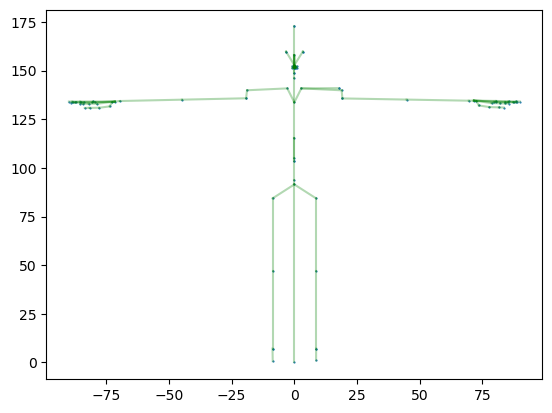

In [46]:
plt.scatter(points[:, 0], points[:, 1], s=0.3)
for edge in edges:
    # if edge[0] in filtering_joints:
    start = offsets[edge[0]]
    end = offsets[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='green', alpha=0.3)

In [26]:
# try to pose joints in similar to pymo way
posed = {}
for joint in sample.traverse():
    if 'Nub' in joint:
        # fictive joint
        rotation = np.zeros(3)
        position = np.array(
            sample.skeleton[joint]['offsets']
        )
    else:
        rotation = [
            sample.values[f'{joint}_Zrotation'][0],
            sample.values[f'{joint}_Xrotation'][0],
            sample.values[f'{joint}_Yrotation'][0]
        ]
        position = np.array([
            sample.values[f'{joint}_Xposition'][0],
            sample.values[f'{joint}_Yposition'][0],
            sample.values[f'{joint}_Zposition'][0]
        ])
    rotmat = R.from_euler('ZXY', rotation, degrees=True)
    posed[joint] = [None, None]
    if joint == sample.root_name:        
        posed[joint][0] = rotmat
        posed[joint][1] = position
    else:
        parent = sample.skeleton[joint]['parent']
        posed[joint][0] = posed[parent][0] * rotmat
        rotated = posed[parent][0].apply(position)
        posed[joint][1] = posed[parent][1] + rotated
        
# sample.values

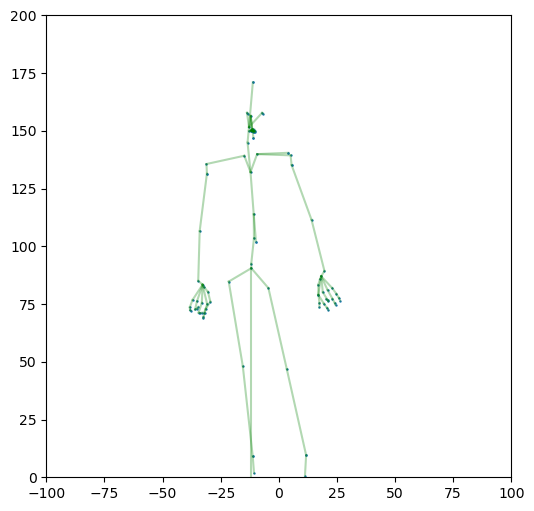

In [45]:
posed_points = np.zeros((len(posed), 3))
for i, joint in enumerate(posed):
    posed_points[i,:] = posed[joint][1]
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim([-100, 100])
ax.set_ylim([0,200])
ax.scatter(posed_points[:, 0], posed_points[:, 1], s=0.5)
for edge in edges:
    # if 'Nub' in edge[0]:
    #     continue
    # if edge[0] in filtering_joints:
    start = posed[edge[0]][1]
    end = posed[edge[1]][1]
    try:
        ax.plot([start[0], end[0]], [start[1], end[1]], color='green', alpha=0.3)
    except Exception as e:
        print(edge)

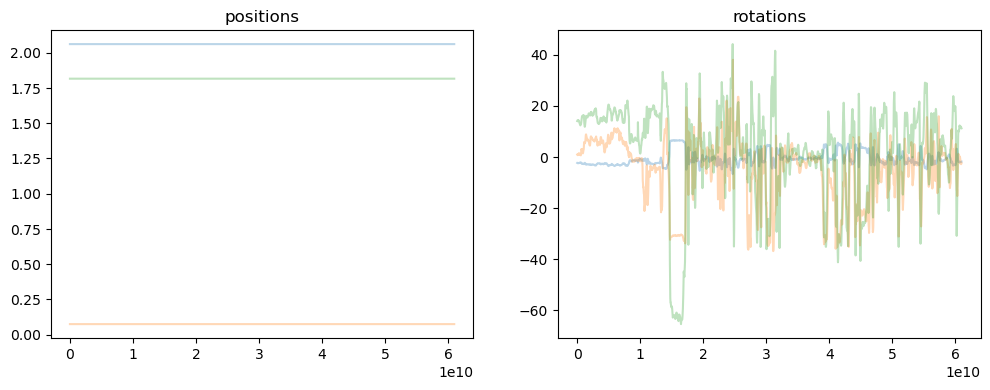

In [204]:
# check if positions are constant on non root joints
def draw_pos_rot(joint):
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(sample.values[f'{joint}_Xposition'], alpha=0.3)
    ax1.plot(sample.values[f'{joint}_Yposition'], alpha=0.3)
    ax1.plot(sample.values[f'{joint}_Zposition'], alpha=0.3)
    ax1.set_title('positions')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(sample.values[f'{joint}_Xrotation'], alpha=0.3)
    ax2.plot(sample.values[f'{joint}_Yrotation'], alpha=0.3)
    ax2.plot(sample.values[f'{joint}_Zrotation'], alpha=0.3)
    ax2.set_title('rotations')    

draw_pos_rot('b_l_wrist')

## Export to Blender
To make appropriate apropriate animation let's try to reconstruct it via Blender

In [21]:
# dump points to load in blender
import json
    
with open('data/json_data.json', 'w') as outfile:
    json.dump(poses[0], outfile, indent=4)

To reconstruct animation from points:
- extract positions via `extract_positions.py` script as above
- Open Blender
- Add `src/blender/body_constructor.py` script to Blender
- fill data path params and run script

Unfortunatelly, even with blender animation reconstruction from joint positions is unstable. So, we'll try to use rotations. 

## 6D Rotation representation
Here we trying to implement 6D rotation representation from [On the Continuity of Rotation Representations in Neural Networks](https://arxiv.org/pdf/1812.07035.pdf)

In [17]:
# first get some rotation matrix
joints = ['b_root', 'b_spine0']
def get_euler(joint):
    euler = [
        sample.values[f'{joint}_Zrotation'][0],
        sample.values[f'{joint}_Xrotation'][0],
        sample.values[f'{joint}_Yrotation'][0]
    ]
    return euler
    
eulers = [get_euler(joint) for joint in joints]
rotmat = R.from_euler('ZXY', eulers, degrees=True)
# rotmat.as_matrix()    

In [9]:
def normalize_batch(batch):
    batch_size = batch.shape[0]
    norm = np.linalg.norm(batch, axis=1)
    return batch / norm.reshape(batch_size, 1)

def rotmats_to_ortho6d(rotmats):
    a1 = rotmats[:,:,0] # Nx3
    a2 = rotmats[:,:,1] # Nx3
    return np.concatenate([a1, a2], axis=-1)
   
def ortho6d_to_rotmats(ortho6d):
    a1, a2 = ortho6d[:,:3], ortho6d[:,3:]
    x = normalize_batch(a1)
    z = np.cross(x, a2)
    z = normalize_batch(z)
    y = np.cross(z, x)
    
    bs = ortho6d.shape[0]
    x = x.reshape(bs, 3, 1)
    y = y.reshape(bs, 3, 1)
    z = z.reshape(bs, 3, 1)
    r  = np.concatenate([x,y,z], axis=-1)
    return r

In [20]:
print(np.linalg.norm(ortho6d_to_rotmats(rotmats_to_ortho6d(rotmat.as_matrix())) -  rotmat.as_matrix()))

3.0174341821701947e-16


# PAE Testing
Now let's investigate trained model

In [27]:
sample_velocities_path = 'data/velocities/val/val_2023_v0_000_main-agent.npy'
sample_positions_path = 'data/positions/val/val_2023_v0_000_main-agent.npy'
sample_mocap = bvh_parser.parse('./data/val/main-agent/bvh/val_2023_v0_000_main-agent.bvh')
sample_velocities = np.load(sample_velocities_path)
sample_positions = np.load(sample_positions_path)

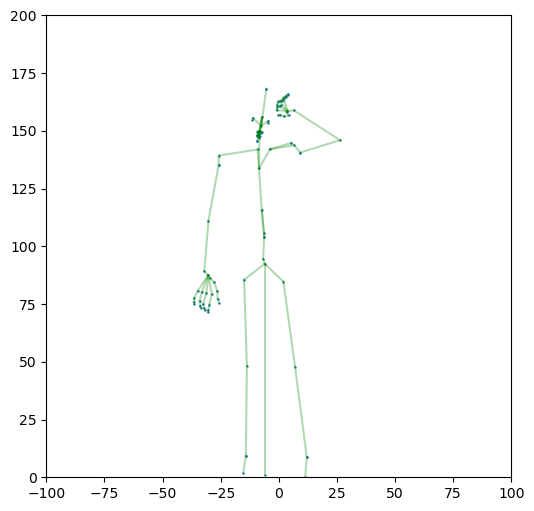

In [28]:
edges = extract_edges(sample_mocap) 
initial_pose = get_pose(sample_mocap, 500)
fig = skeleton_pose2d(initial_pose, edges)
fig.canvas.draw()

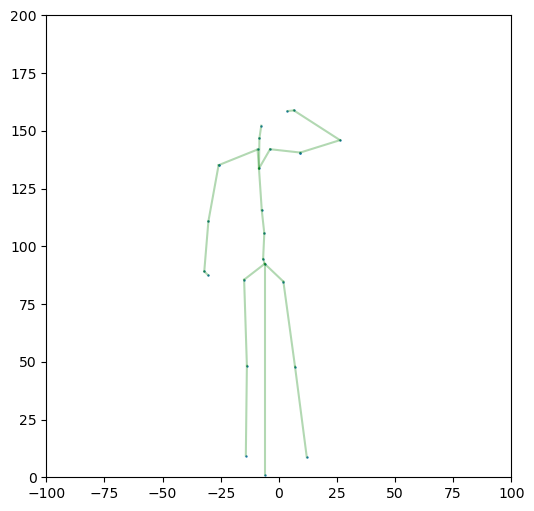

In [31]:
pose_from_positions = pose_from_numpy(sample_positions[500], filtering_joints)
fig = skeleton_pose2d(pose_from_positions, edges)
fig.canvas.draw()

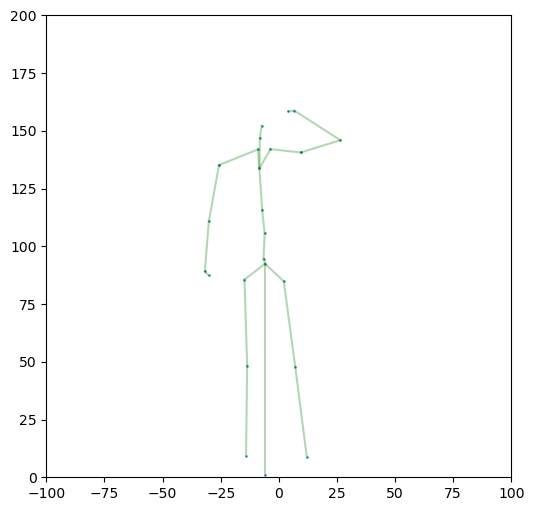

In [32]:
pose_from_positions = pose_from_numpy(sample_positions[0] + np.sum(sample_velocities[:500], axis=0), filtering_joints)
fig = skeleton_pose2d(pose_from_positions, edges)
fig.canvas.draw()

In [13]:
from src.pae.system import PAESystem
from src.pae.dataset import AutoEncoderDataset

In [14]:
system = PAESystem(
    joints = 26,
    channels = 3,
    phases = 8,
    window = 2.0,
    fps = 30,
    learning_rate = 1e-4,
    batch_size = 512,
    trn_folder = 'data/velocities/trn',
    val_folder = 'data/velocities/val'
)

372it [00:01, 298.31it/s]
41it [00:00, 810.36it/s]


In [15]:
dataset = AutoEncoderDataset([Path(sample_velocities_path)], window=2.0, fps=30)

1it [00:00, 930.83it/s]


In [17]:
import torch
checkpoint_path = 'data/models/pae_joint_vel_best.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
system.load_state_dict(checkpoint['state_dict'])
system.eval()

PAESystem(
  (model): PhaseAutoEncoder(
    (conv1): Conv1d(78, 26, kernel_size=(61,), stride=(1,), padding=(30,))
    (norm1): InstanceNorm()
    (conv2): Conv1d(26, 8, kernel_size=(61,), stride=(1,), padding=(30,))
    (fc): ModuleList(
      (0-7): 8 x Linear(in_features=61, out_features=2, bias=True)
    )
    (deconv1): Conv1d(8, 26, kernel_size=(61,), stride=(1,), padding=(30,))
    (denorm1): InstanceNorm()
    (deconv2): Conv1d(26, 78, kernel_size=(61,), stride=(1,), padding=(30,))
  )
  (mse): MSELoss()
)

In [18]:
items = [dataset[i] for i in range(500)]
batch = torch.stack(items, dim=0)
with torch.no_grad():
    y, latent, signal, params = system.forward(batch)

In [19]:
p, f, a, b = params

In [20]:
sample_positions[0].shape

(78,)

In [21]:
y.shape

torch.Size([500, 61, 78])

In [22]:
reconstructed_positions = [sample_positions[0] + y[0,30,:].detach().numpy()]
for i in range(1, y.shape[0]):
    reconstructed_positions.append(reconstructed_positions[i-1] +  y[i,30,:].detach().numpy())

reconstructed_positions = np.stack(reconstructed_positions)
reconstructed_positions.shape

(500, 78)

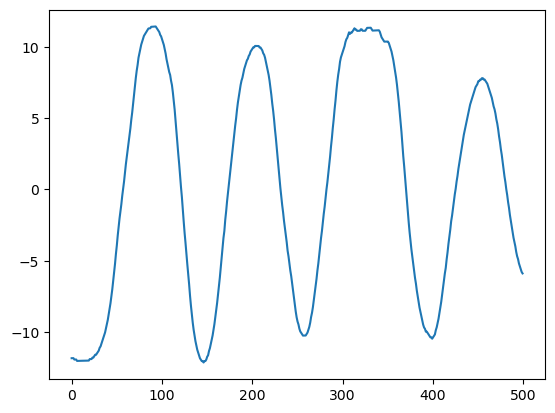

In [23]:
plt.plot(sample_positions[:500, 0])

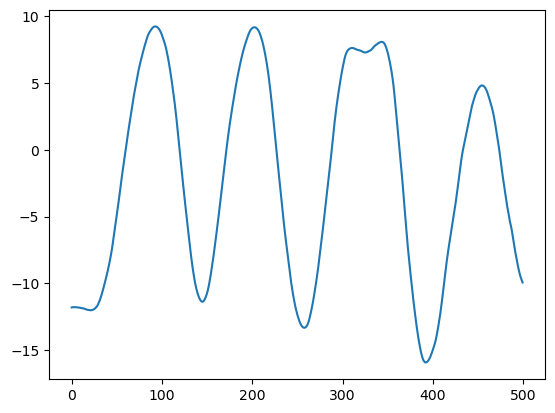

In [24]:
plt.plot(reconstructed_positions[:, 0])

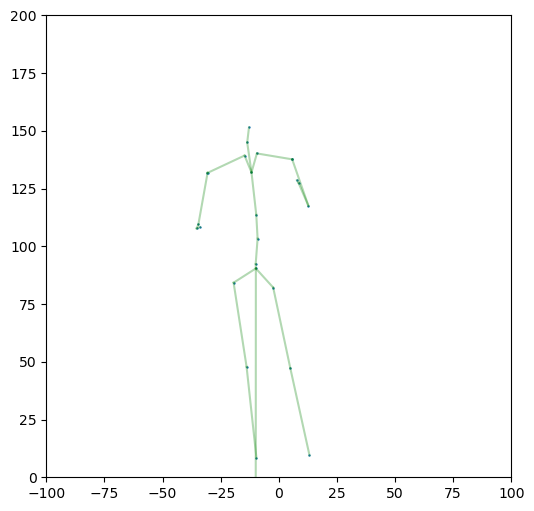

In [33]:
pose_from_positions = pose_from_numpy(reconstructed_positions[-1], filtering_joints)
fig = skeleton_pose2d(pose_from_positions, edges)
fig.canvas.draw()

In [65]:
poses = np.array([pose_from_numpy(reconstructed_positions[i], filtering_joints) for i in  range(reconstructed_positions.shape[0])])
skeleton_gif2d(poses, edges, Path('results/pae_joint_vel/rec500.gif'))

In [68]:
# sample_positions[0] + np.sum(sample_velocities[:500], axis=0)
smoothed_positions = [sample_positions[0] + sample_velocities[0]]
for i in range(1, y.shape[0]):
    smoothed_positions.append(smoothed_positions[i-1] + sample_velocities[i])

poses = np.array([pose_from_numpy(smoothed_positions[i], filtering_joints) for i in  range(len(smoothed_positions))])
skeleton_gif2d(poses, edges, Path('data/pos/sample.gif'))

## Plotting phases

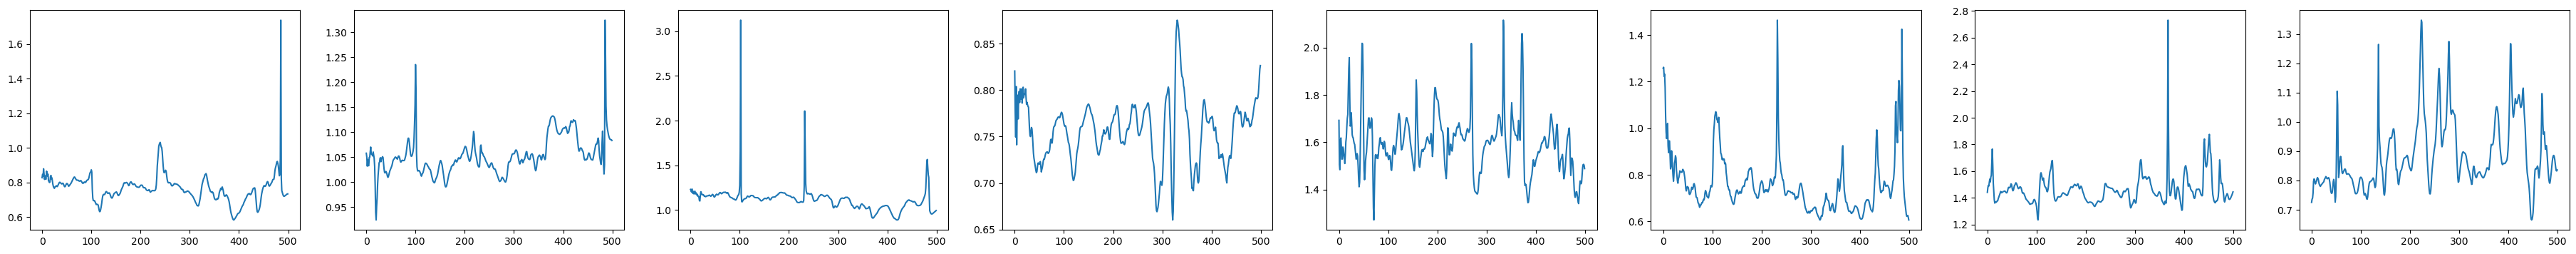

In [34]:
fig = plt.figure(figsize=(46,4))
for i in range(f.shape[1]):
    ax = fig.add_subplot(1, 8, i+1)
    ax.plot(f.squeeze(2).detach().numpy()[:,i])

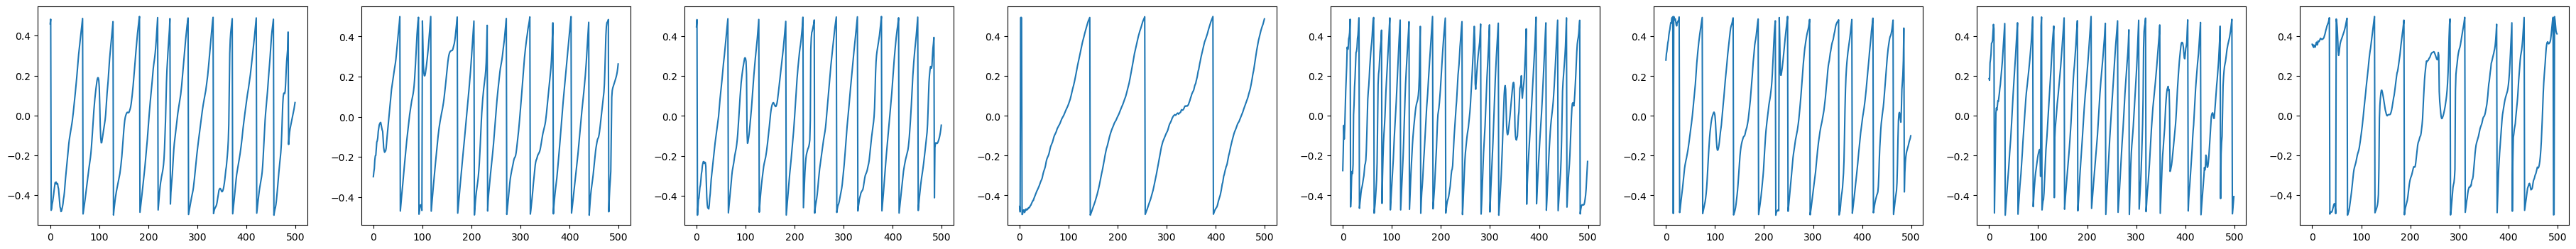

In [35]:
fig = plt.figure(figsize=(46,4))
for i in range(p.shape[1]):
    ax = fig.add_subplot(1, 8, i+1)
    ax.plot(p.squeeze(2).detach().numpy()[:,i])

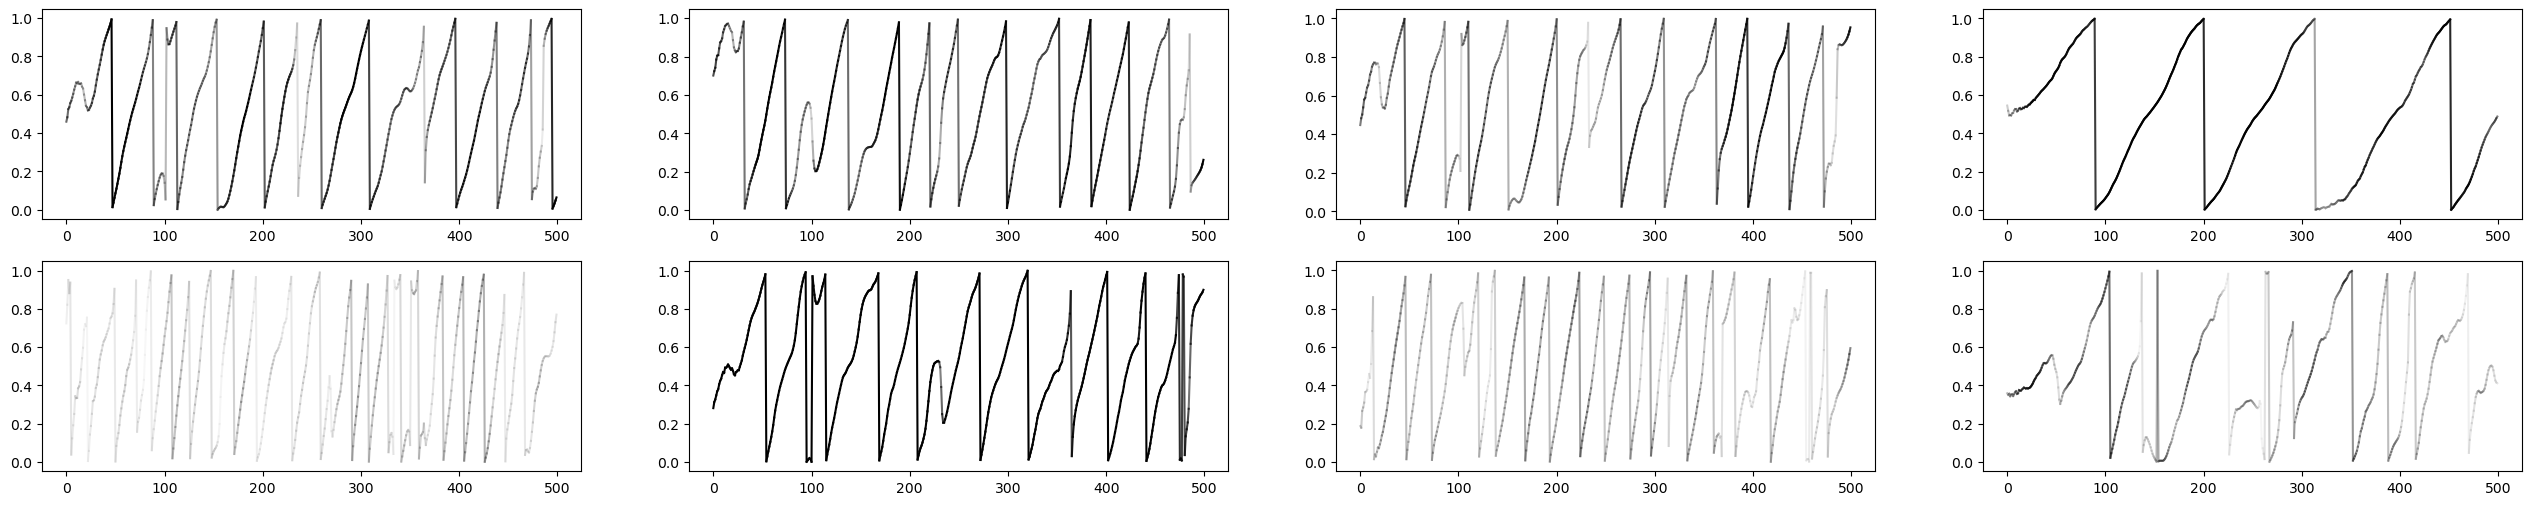

In [36]:
fig = plt.figure(figsize=(32,6))
for i in range(p.shape[1]):
    ax = fig.add_subplot(2, 4, i+1)
    phase = p.squeeze(2).detach().numpy()[:,i]
    phase = np.where(phase < 0, phase, phase + 1)
    phase = phase % 1.0
    amp = a.squeeze(2).detach().numpy()[:,i]
   
    opacity = np.clip(amp, 0, 1)
    args = np.arange(len(phase))
    for i in range(1, len(phase)):
        ax.plot([args[i-1], args[i]], [phase[i-1], phase[i]], color=(0,0,0, opacity[i]))

In [37]:
phase.shape

(500,)

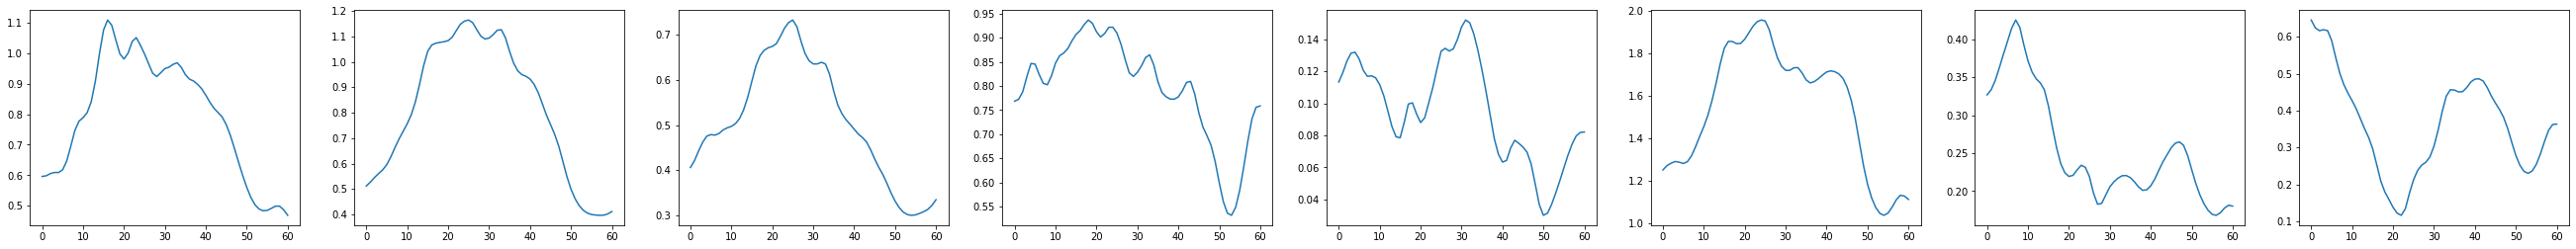

In [77]:
fig = plt.figure(figsize=(46,4))
for i in range(a.shape[1]):
    ax = fig.add_subplot(1, 8, i+1)
    ax.plot(a.squeeze(2).detach().numpy()[:,i])

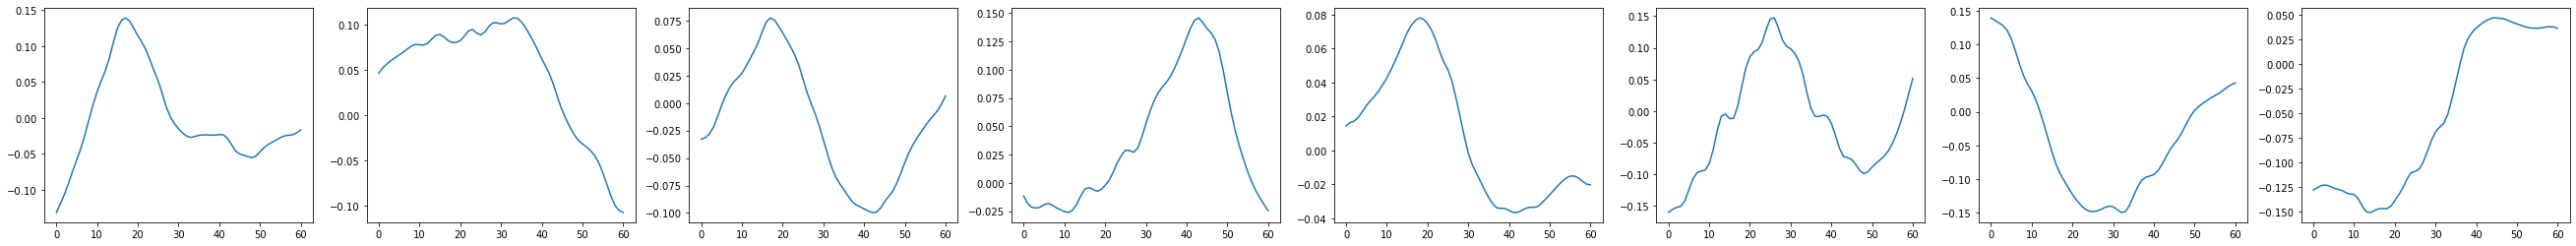

In [78]:
fig = plt.figure(figsize=(46,4))
for i in range(b.shape[1]):
    ax = fig.add_subplot(1, 8, i+1)
    ax.plot(b.squeeze(2).detach().numpy()[:,i])

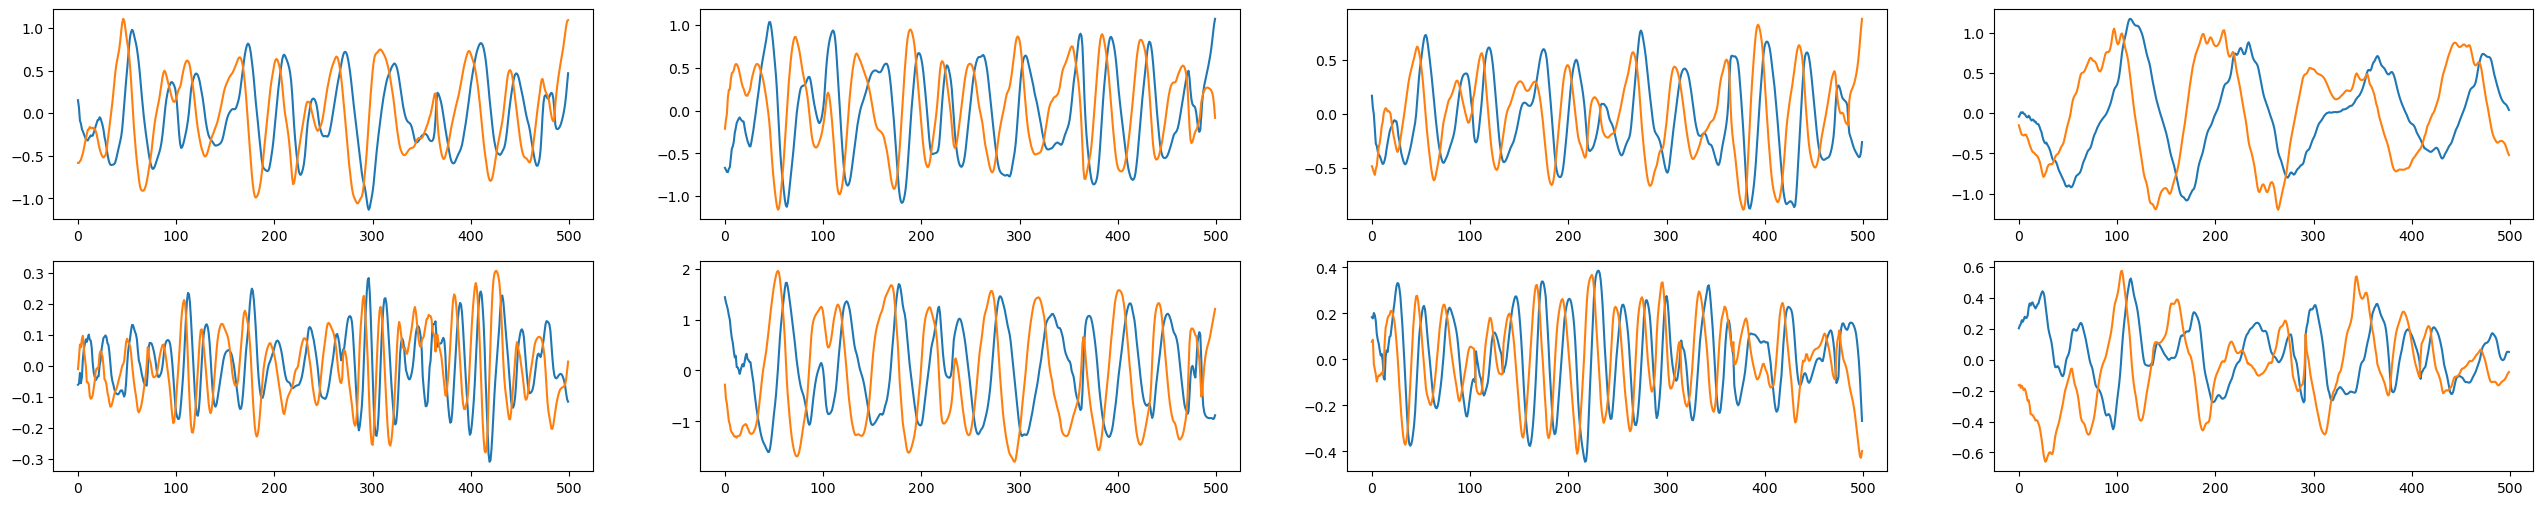

In [38]:
fig = plt.figure(figsize=(32,6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    phase =  p.squeeze(2).detach().numpy()[:,i]
    amp = a.squeeze(2).detach().numpy()[:,i]
    phaseX = amp * np.sin(2*np.pi*phase)
    phaseY = amp * np.cos(2*np.pi*phase)
    ax.plot(phaseX)
    ax.plot(phaseY)

In [41]:
phaseX.shape

(500,)

In [42]:
np.stack([phaseX, phaseY], axis=-1).shape

(500, 2)

In [43]:
dataset_sample_path = 'data/dataset_simple/val/val_2023_v0_000_main-agent.npz'
dataset_sample = np.load(dataset_sample_path)

In [44]:
dataset_sample['Audio'].shape, dataset_sample['Motion'].shape, dataset_sample['Phase'].shape

((1831, 26), (1830, 150), (1830, 16))

## PAE ortho6d
Now let's check what if training PAE on ortho6d representation

In [116]:
sample_ortho6d_path = 'data/ortho6d_from_desktop/val_2023_v0_000_main-agent_fixed.npy'
sample_ortho6d = np.load(sample_ortho6d_path)

In [117]:
from src.pae.system import PAESystem
from src.pae.dataset import AutoEncoderDataset

In [136]:
system = PAESystem(
    joints=25, 
    channels=6, 
    phases=8,
    window=2.0,
    fps=30, 
    learning_rate=1e-4,
    batch_size = 512,
    trn_folder = 'data/ortho6d_from_desktop/',
    val_folder = 'data/ortho6d_from_desktop/',
    add_root = True
)


5it [00:00, 131.30it/s]
5it [00:00, 296.51it/s]


In [119]:
dataset = AutoEncoderDataset([Path(sample_ortho6d_path)], window=2.0, fps=30)

1it [00:00, 137.13it/s]


In [137]:
checkpoint_path = 'data/ortho6d_from_desktop/pae_ortho6d_8p_e59.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
system.load_state_dict(checkpoint['state_dict'])
system.eval()

PAESystem(
  (model): PhaseAutoEncoder(
    (conv1): Conv1d(153, 26, kernel_size=(61,), stride=(1,), padding=(30,))
    (norm1): InstanceNorm()
    (conv2): Conv1d(26, 8, kernel_size=(61,), stride=(1,), padding=(30,))
    (fc): ModuleList(
      (0-7): 8 x Linear(in_features=61, out_features=2, bias=True)
    )
    (deconv1): Conv1d(8, 26, kernel_size=(61,), stride=(1,), padding=(30,))
    (denorm1): InstanceNorm()
    (deconv2): Conv1d(26, 153, kernel_size=(61,), stride=(1,), padding=(30,))
  )
  (mse): MSELoss()
  (geodesic): GeodesicLoss()
)

In [138]:
items = [dataset[i] for i in range(1830)]
batch = torch.stack(items, dim=0)
with torch.no_grad():
    y, latent, signal, params = system.forward(batch)

In [139]:
# y.shape
frames = np.zeros((y.shape[0], y.shape[-1]))
for i in range(y.shape[0]):
    frames[i, :] = y[i, 30, :]

In [140]:
frames.shape

(1830, 153)

In [141]:
np.save('data/ortho6d_from_desktop/val_000_reconstructed_8p_e59.npy', frames)

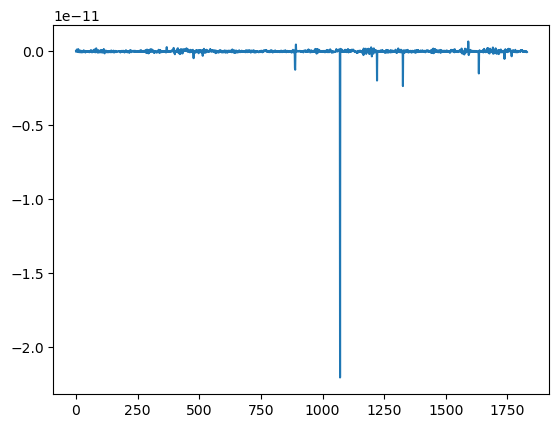

In [142]:
plt.plot(sample_ortho6d[:, 8])

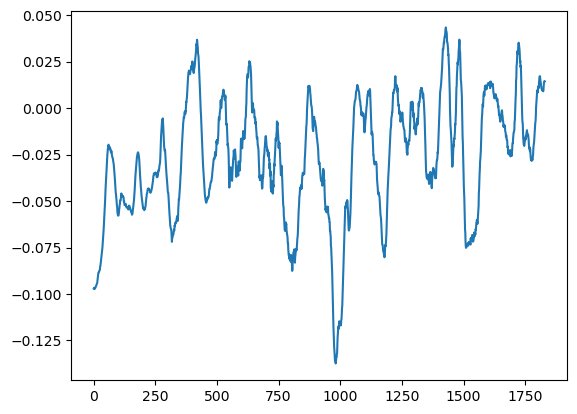

In [143]:
plt.plot(frames[:, 8])

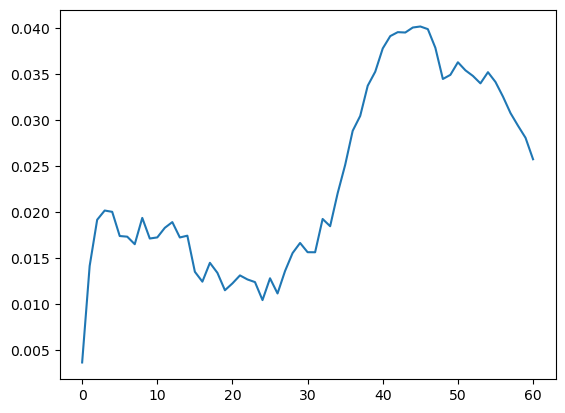

In [144]:
plt.plot(y[30, :, 2].detach().numpy())

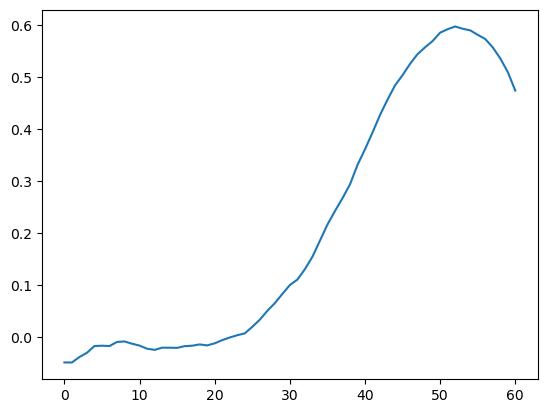

In [145]:
plt.plot(y[30, :, -3].detach().numpy())

In [146]:
p, f, a, b = params

In [127]:
f.shape

torch.Size([1830, 8, 1])

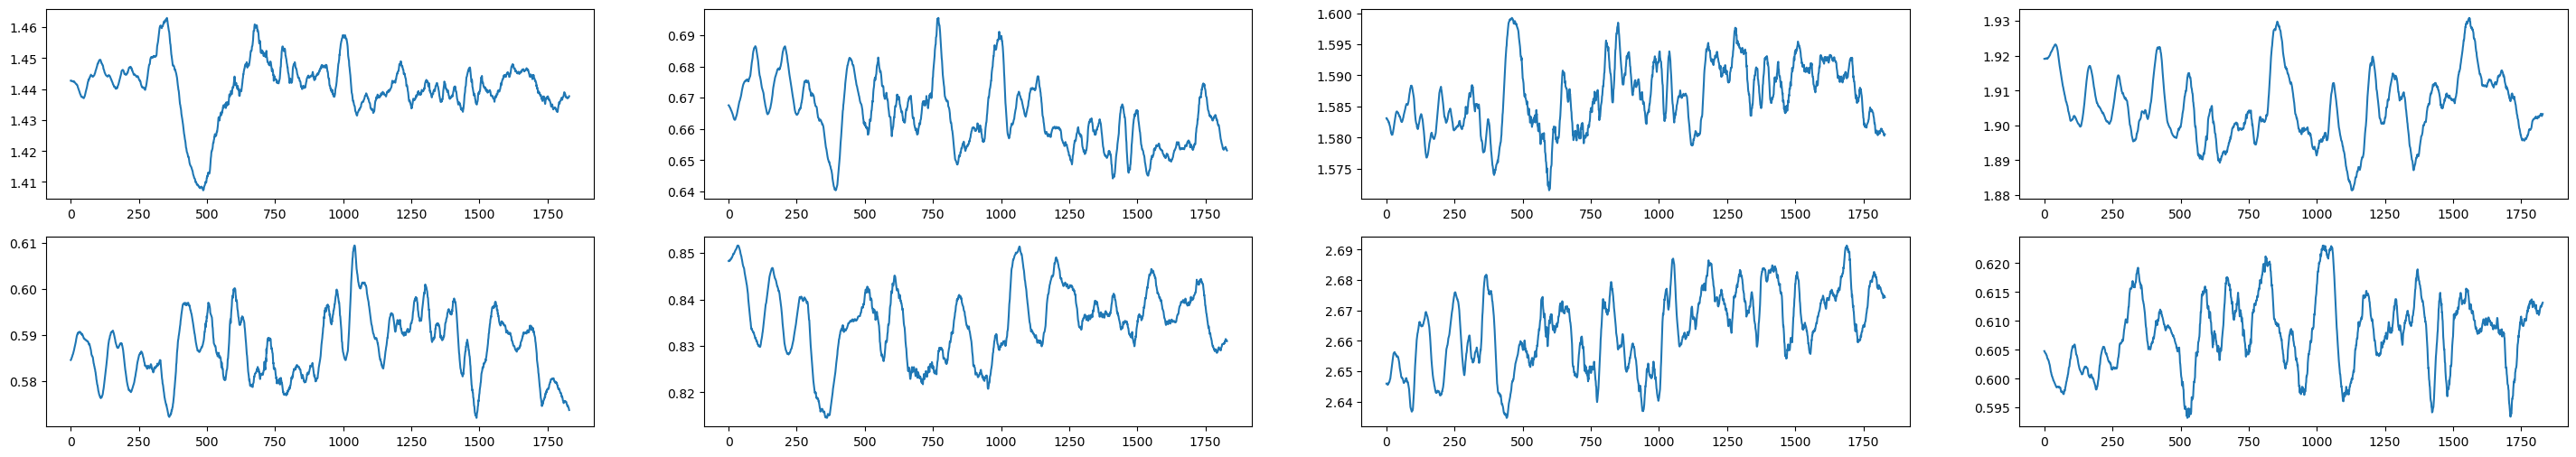

In [147]:
fig = plt.figure(figsize=(36,6))
for i in range(f.shape[1]):
    ax = fig.add_subplot(2, f.shape[1] // 2, i+1)
    ax.plot(f.squeeze(2).detach().numpy()[:, i])

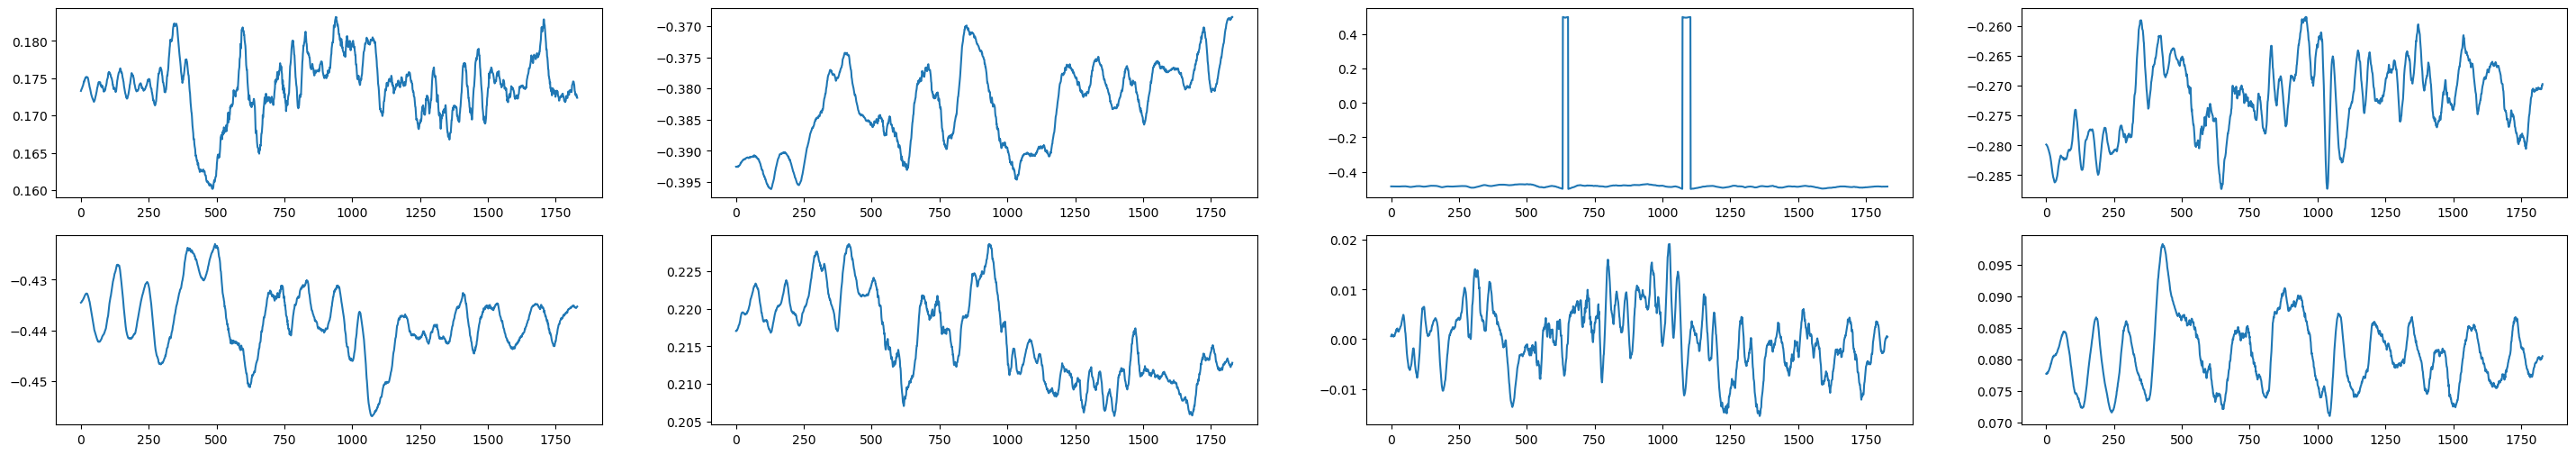

In [148]:
fig = plt.figure(figsize=(36,6))
for i in range(p.shape[1]):
    ax = fig.add_subplot(2, p.shape[1] // 2, i+1)
    ax.plot(p.squeeze(2).detach().numpy()[:, i])

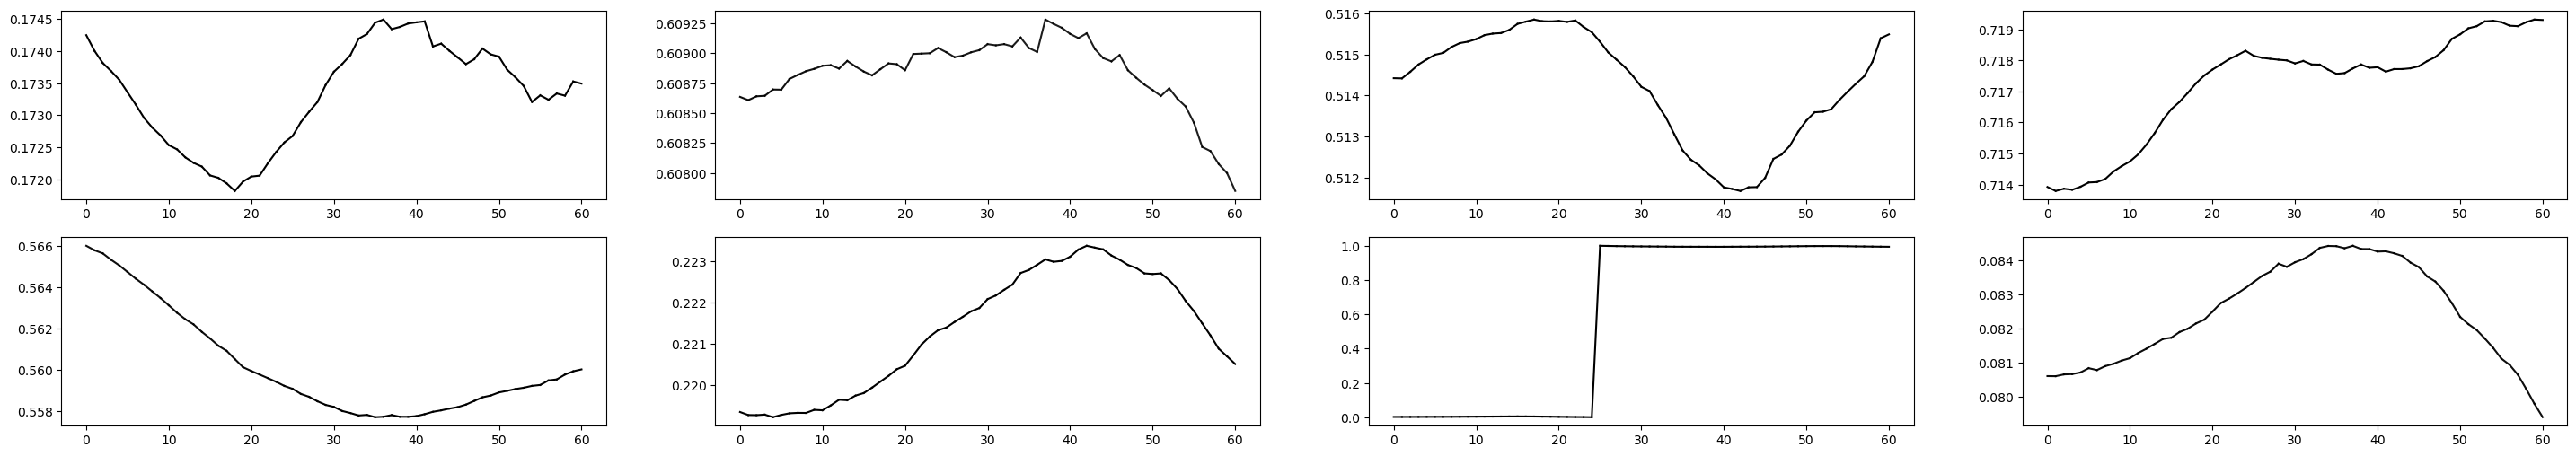

In [149]:
fig = plt.figure(figsize=(36,6))
for i in range(p.shape[1]):
    ax = fig.add_subplot(2, p.shape[1] // 2, i+1)
    phase = p.squeeze(2).detach().numpy()[30:91,i]
    phase = np.where(phase < 0, phase, phase + 1)
    phase = phase % 1.0
    amp = a.squeeze(2).detach().numpy()[30:91,i]
   
    opacity = np.clip(amp, 0, 1)
    args = np.arange(len(phase))
    for i in range(1, len(phase)):
        ax.plot([args[i-1], args[i]], [phase[i-1], phase[i]], color=(0,0,0, opacity[i]))

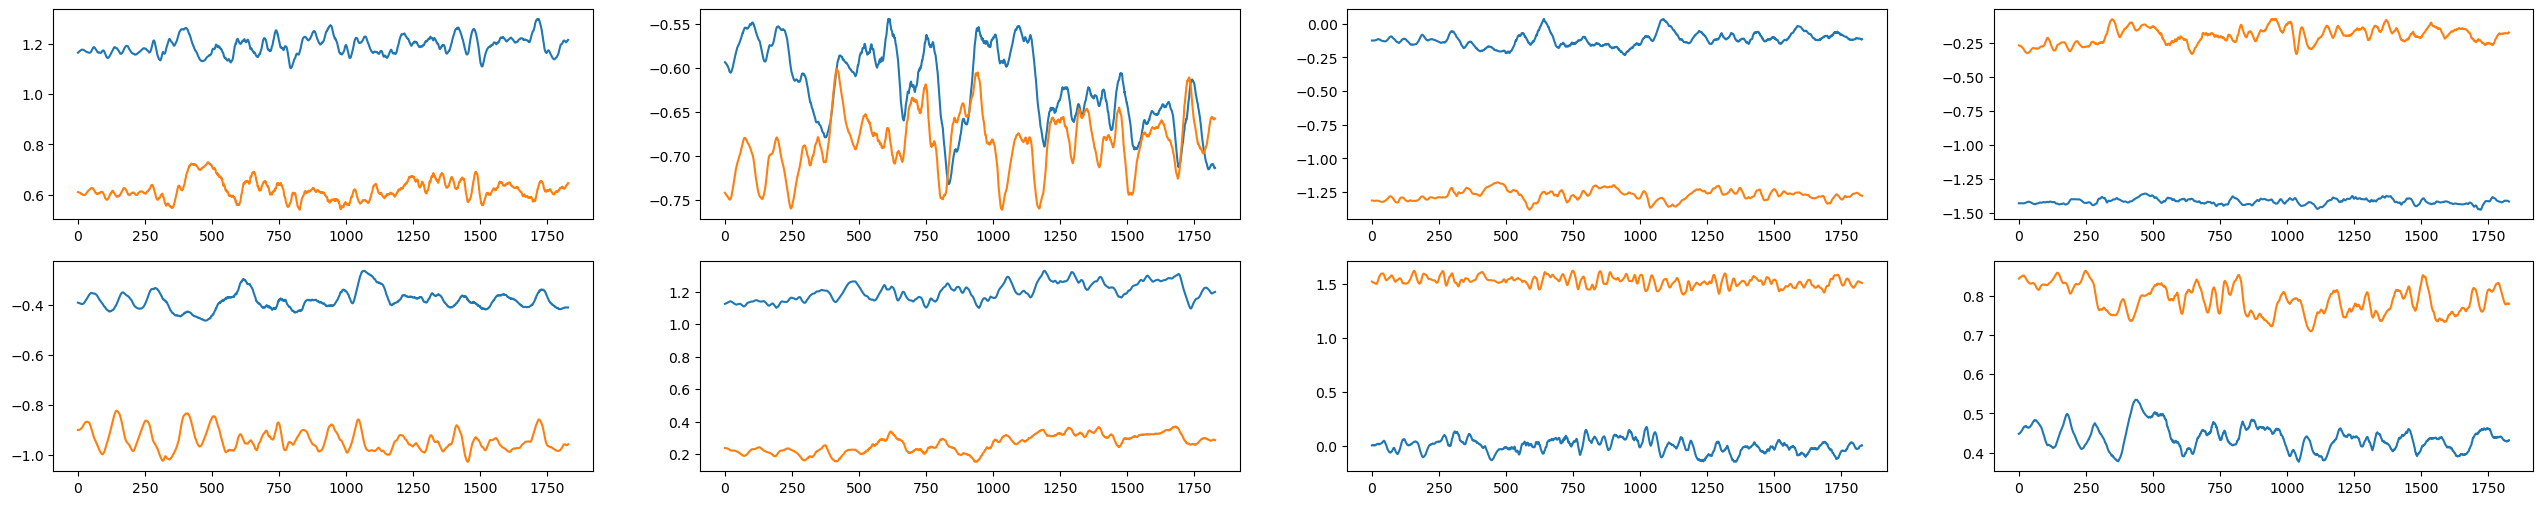

In [150]:
fig = plt.figure(figsize=(32,6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    phase =  p.squeeze(2).detach().numpy()[:,i]
    amp = a.squeeze(2).detach().numpy()[:,i]
    phaseX = amp * np.sin(2*np.pi*phase)
    phaseY = amp * np.cos(2*np.pi*phase)
    ax.plot(phaseX)
    ax.plot(phaseY)

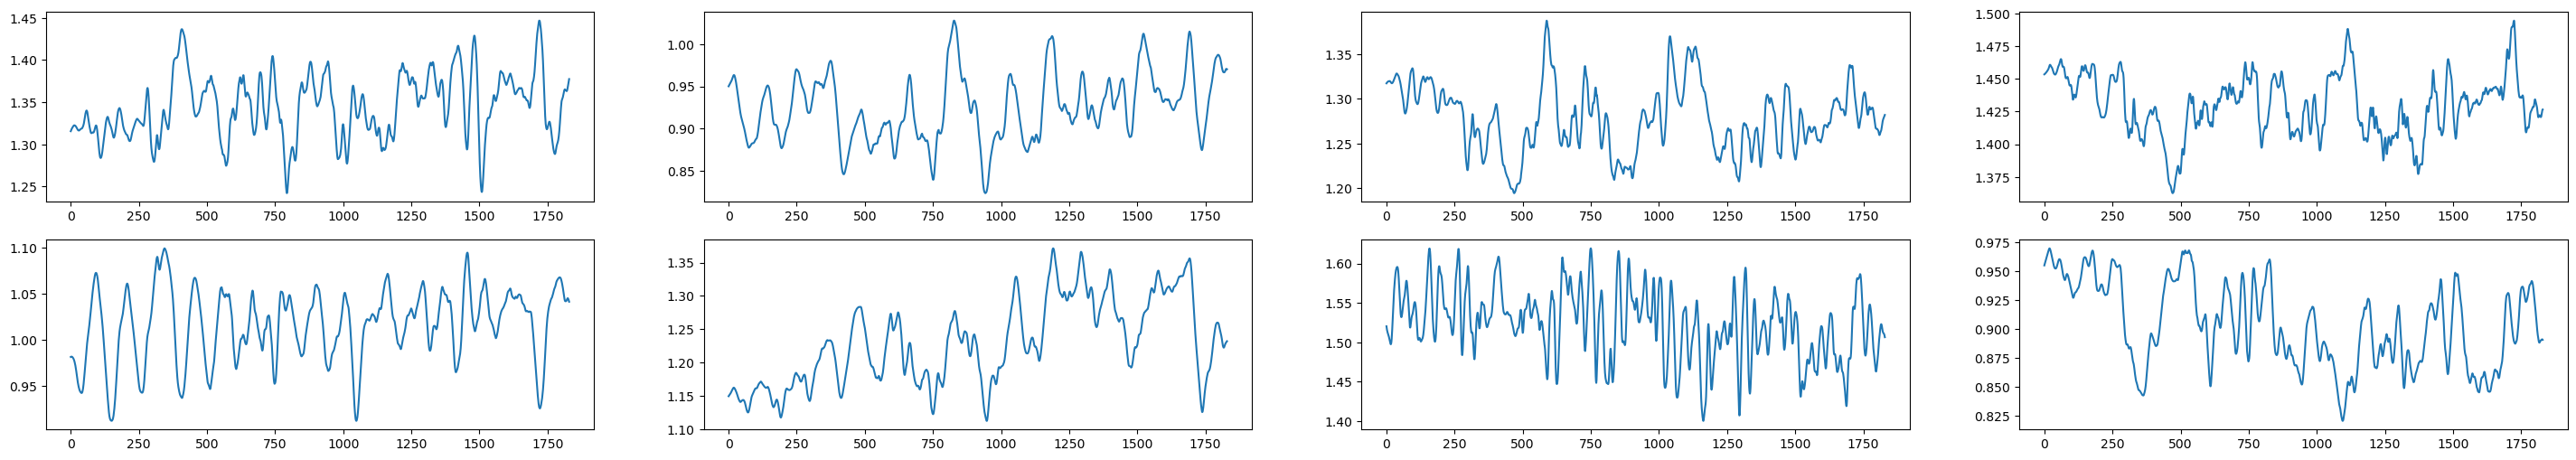

In [151]:
fig = plt.figure(figsize=(36,6))
for i in range(a.shape[1]):
    ax = fig.add_subplot(2, a.shape[1] // 2, i+1)
    ax.plot(a.squeeze(2).detach().numpy()[:,i])

## Test SAE


In [106]:
from src.sae.system import SAESystem
sae_system = SAESystem(
    input_dim = 150,
    trn_folder = 'data/ortho6d_from_desktop/val_fixed',
    val_folder = 'data/ortho6d_from_desktop/val_fixed',
    loss_name = "geodesic",
    batch_size = 512    
)

41it [00:00, 490.15it/s]
41it [00:00, 1334.32it/s]


In [107]:
# checkpoint_path = 'results/sae_geodesic/epoch=91-step=366436.ckpt'
checkpoint_path = 'results/sae_mse/epoch=97-step=390334.ckpt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
sae_system.load_state_dict(checkpoint['state_dict'])
sae_system.eval()

SAESystem(
  (model): SimpleAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=150, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=25, bias=True)
      (3): Sigmoid()
    )
    (decoder): Sequential(
      (0): Linear(in_features=25, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=150, bias=True)
    )
  )
  (loss): GeodesicLoss()
)

In [108]:
from src.sae.dataset import SimpleMotionDataset
sample_sae_path = 'data/ortho6d_from_desktop/val_fixed/val_2023_v0_000_main-agent.npy'
dataset = SimpleMotionDataset([Path(sample_sae_path)])

1it [00:00, 193.36it/s]


In [109]:
batch.shape

torch.Size([1830, 150])

In [110]:
items = [dataset[i] for i in range(1830)]
batch = torch.stack(items, dim=0)
with torch.no_grad():
    sae_result = sae_system.forward(batch)

In [111]:
sae_result_np = sae_result.detach().numpy()
# plt.plot(sae_result.shape

In [112]:
original_data = np.load(sample_sae_path)

In [113]:
original_data.shape

(1830, 150)

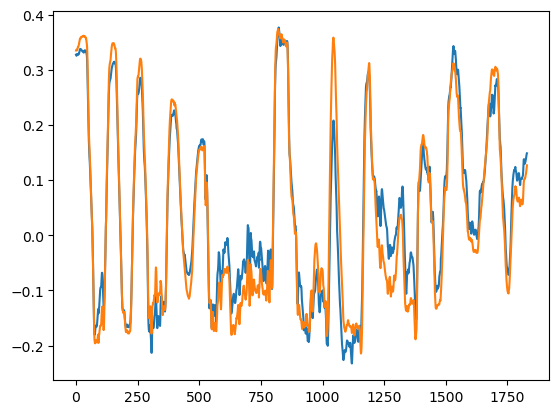

In [114]:
plt.plot(sae_result_np[:, 13])
plt.plot(original_data[:, 13])

In [115]:
np.save('data/ortho6d_from_desktop/sae_sample_mse.npy', sae_result_np)

## Debug pipeline

In [48]:
fixed_data = np.load('data/ortho6d_with_root/val_fixed/val_2023_v0_000_main-agent.npy')

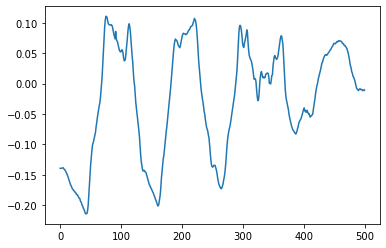

In [61]:
plt.plot(fixed_data[:500, 145])

In [25]:
columns = ['b_l_foot_a1x', 'b_l_leg_a1x', 'b_l_upleg_a1x', 'b_r_foot_a1x', 'b_r_leg_a1x', 'b_r_upleg_a1x', 'b_l_wrist_a1x', 'b_l_wrist_twist_a1x', 'b_l_forearm_a1x', 'b_l_arm_twist_a1x',
            'b_l_arm_a1x', 'b_l_shoulder_a1x', 'b_r_wrist_a1x', 'b_r_wrist_twist_a1x', 'b_r_forearm_a1x', 'b_r_arm_twist_a1x', 'b_r_arm_a1x', 'b_r_shoulder_a1x', 'b_head_a1x', 'b_neck0_a1x',
            'b_spine3_a1x', 'b_spine2_a1x', 'b_spine1_a1x', 'b_spine0_a1x', 'b_root_a1x', 'b_l_foot_a1y', 'b_l_leg_a1y', 'b_l_upleg_a1y', 'b_r_foot_a1y', 'b_r_leg_a1y', 'b_r_upleg_a1y', 'b_l_wrist_a1y',
            'b_l_wrist_twist_a1y', 'b_l_forearm_a1y', 'b_l_arm_twist_a1y', 'b_l_arm_a1y', 'b_l_shoulder_a1y', 'b_r_wrist_a1y', 'b_r_wrist_twist_a1y', 'b_r_forearm_a1y', 'b_r_arm_twist_a1y', 'b_r_arm_a1y',
            'b_r_shoulder_a1y', 'b_head_a1y', 'b_neck0_a1y', 'b_spine3_a1y', 'b_spine2_a1y', 'b_spine1_a1y', 'b_spine0_a1y', 'b_root_a1y', 'b_l_foot_a1z', 'b_l_leg_a1z', 'b_l_upleg_a1z', 'b_r_foot_a1z',
            'b_r_leg_a1z', 'b_r_upleg_a1z', 'b_l_wrist_a1z', 'b_l_wrist_twist_a1z', 'b_l_forearm_a1z', 'b_l_arm_twist_a1z', 'b_l_arm_a1z', 'b_l_shoulder_a1z', 'b_r_wrist_a1z', 'b_r_wrist_twist_a1z', 
            'b_r_forearm_a1z', 'b_r_arm_twist_a1z', 'b_r_arm_a1z', 'b_r_shoulder_a1z', 'b_head_a1z', 'b_neck0_a1z', 'b_spine3_a1z', 'b_spine2_a1z', 'b_spine1_a1z', 'b_spine0_a1z', 'b_root_a1z', 'b_l_foot_a2x',
            'b_l_leg_a2x', 'b_l_upleg_a2x', 'b_r_foot_a2x', 'b_r_leg_a2x', 'b_r_upleg_a2x', 'b_l_wrist_a2x', 'b_l_wrist_twist_a2x', 'b_l_forearm_a2x', 'b_l_arm_twist_a2x', 'b_l_arm_a2x', 'b_l_shoulder_a2x',
            'b_r_wrist_a2x', 'b_r_wrist_twist_a2x', 'b_r_forearm_a2x', 'b_r_arm_twist_a2x', 'b_r_arm_a2x', 'b_r_shoulder_a2x', 'b_head_a2x', 'b_neck0_a2x', 'b_spine3_a2x', 'b_spine2_a2x', 'b_spine1_a2x', 'b_spine0_a2x',
            'b_root_a2x', 'b_l_foot_a2y', 'b_l_leg_a2y', 'b_l_upleg_a2y', 'b_r_foot_a2y', 'b_r_leg_a2y', 'b_r_upleg_a2y', 'b_l_wrist_a2y', 'b_l_wrist_twist_a2y', 'b_l_forearm_a2y', 'b_l_arm_twist_a2y',
            'b_l_arm_a2y', 'b_l_shoulder_a2y', 'b_r_wrist_a2y', 'b_r_wrist_twist_a2y', 'b_r_forearm_a2y', 'b_r_arm_twist_a2y', 'b_r_arm_a2y', 'b_r_shoulder_a2y', 'b_head_a2y', 'b_neck0_a2y', 'b_spine3_a2y', 'b_spine2_a2y',
            'b_spine1_a2y', 'b_spine0_a2y', 'b_root_a2y', 'b_l_foot_a2z', 'b_l_leg_a2z', 'b_l_upleg_a2z', 'b_r_foot_a2z', 'b_r_leg_a2z', 'b_r_upleg_a2z', 'b_l_wrist_a2z', 'b_l_wrist_twist_a2z', 'b_l_forearm_a2z', 'b_l_arm_twist_a2z', 
            'b_l_arm_a2z', 'b_l_shoulder_a2z', 'b_r_wrist_a2z', 'b_r_wrist_twist_a2z', 'b_r_forearm_a2z', 'b_r_arm_twist_a2z', 'b_r_arm_a2z', 'b_r_shoulder_a2z', 'b_head_a2z', 'b_neck0_a2z', 'b_spine3_a2z', 'b_spine2_a2z', 'b_spine1_a2z',
            'b_spine0_a2z', 'b_root_a2z', 'body_world_Xposition', 'body_world_Yposition', 'body_world_Zposition']


In [30]:
joints_num = (len(columns) - 3) // 6

In [31]:
for i in range(joints_num):
    print(columns[i], columns[i+25], columns[i+2*25], columns[i+3*25], columns[i+4*25], columns[i+5*25])

b_l_foot_a1x b_l_foot_a1y b_l_foot_a1z b_l_foot_a2x b_l_foot_a2y b_l_foot_a2z
b_l_leg_a1x b_l_leg_a1y b_l_leg_a1z b_l_leg_a2x b_l_leg_a2y b_l_leg_a2z
b_l_upleg_a1x b_l_upleg_a1y b_l_upleg_a1z b_l_upleg_a2x b_l_upleg_a2y b_l_upleg_a2z
b_r_foot_a1x b_r_foot_a1y b_r_foot_a1z b_r_foot_a2x b_r_foot_a2y b_r_foot_a2z
b_r_leg_a1x b_r_leg_a1y b_r_leg_a1z b_r_leg_a2x b_r_leg_a2y b_r_leg_a2z
b_r_upleg_a1x b_r_upleg_a1y b_r_upleg_a1z b_r_upleg_a2x b_r_upleg_a2y b_r_upleg_a2z
b_l_wrist_a1x b_l_wrist_a1y b_l_wrist_a1z b_l_wrist_a2x b_l_wrist_a2y b_l_wrist_a2z
b_l_wrist_twist_a1x b_l_wrist_twist_a1y b_l_wrist_twist_a1z b_l_wrist_twist_a2x b_l_wrist_twist_a2y b_l_wrist_twist_a2z
b_l_forearm_a1x b_l_forearm_a1y b_l_forearm_a1z b_l_forearm_a2x b_l_forearm_a2y b_l_forearm_a2z
b_l_arm_twist_a1x b_l_arm_twist_a1y b_l_arm_twist_a1z b_l_arm_twist_a2x b_l_arm_twist_a2y b_l_arm_twist_a2z
b_l_arm_a1x b_l_arm_a1y b_l_arm_a1z b_l_arm_a2x b_l_arm_a2y b_l_arm_a2z
b_l_shoulder_a1x b_l_shoulder_a1y b_l_shoulder_a1z b

In [26]:
channels_by_joint = {}
for column in columns:
    values = column.split('_')
    joint = '_'.join(values[:-1])
    channel = values[-1]
    if joint not in channels_by_joint:
        channels_by_joint[joint] = set()
    channels_by_joint[joint].add(channel)